In [1]:
import os
import sys
import tensorflow as tf
import common
import SRHW_model
import torch
import numpy as np
import pycuda.autoinit
import tensorrt as trt
from matplotlib import pyplot as plt 
import h5py
from torchsummary import summary
from NumPyNet.layers.shuffler_layer import Shuffler_layer
np.set_printoptions(threshold=sys.maxsize)
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F

import cv2
import datetime

2021-10-16 18:23:19.971526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:


model = SRHW_model.Model()
#mnist_model.learn()
weights = model.get_weights()

SRHW(
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (DWConv1): Conv2d(32, 32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), groups=32, bias=False)
  (PWConv1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv2): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), groups=16, bias=False)
  (PWConv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (PWConv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
  (PWConv4): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (PS): PixelShuffle(upscale_factor=2)
  (relu): ReLU()
)


In [3]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

class ModelData(object):
    INPUT_NAME = "Conv1"
    INPUT_SHAPE = (1, 400, 400)
    OUTPUT_NAME = "prob"
#     OUTPUT_SIZE = 10
    DTYPE = trt.float32

In [4]:

def populate_network(network, weights):
    # Configure the network layers based on the weights provided.
    

    #line1
    
    input_tensor = network.add_input(name=ModelData.INPUT_NAME, dtype=ModelData.DTYPE, shape=ModelData.INPUT_SHAPE)

    conv1_w = weights['Conv1.weight'].numpy()
    
    
    
    conv1 = network.add_convolution_nd(input=input_tensor, num_output_maps=32, kernel_shape=(3,3), kernel=conv1_w)
    
    
    conv1.stride_nd = (1, 1)
    conv1.padding_nd = (1,1)
    
#     quant1=network.add_quantize(input_tensor,1.0)
    
   
    #
    scale1=network.add_scale(input=conv1.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
    #
    
    
    #line2

    relu1 = network.add_activation(input=scale1.get_output(0), type=trt.ActivationType.RELU)

   
    #
    
    #line3
    
    conv2_w = weights['DWConv1.weight'].numpy()
   
    conv2 = network.add_convolution_nd(input=relu1.get_output(0), num_output_maps=32, kernel_shape=(1,5), kernel=conv2_w)
    conv2.stride_nd = (1, 1)
    conv2.padding_nd=(0,2)
    conv2.num_groups=32
    
  
    #
    
    
    scale2=network.add_scale(input=conv2.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
 
    #
    
    
    
    conv3_w = weights['PWConv1.weight'].numpy()
   
    conv3 = network.add_convolution_nd(input=scale2.get_output(0), num_output_maps=16, kernel_shape=(1,1), kernel=conv3_w)
    conv3.stride_nd = (1, 1)

    
    scale3=network.add_scale(input=conv3.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
    relu2 = network.add_activation(input=scale3.get_output(0), type=trt.ActivationType.RELU) #1

    
    
    
    #line4
    
    
    
    conv4_w = weights['DWConv2.weight'].numpy()
    
    conv4 = network.add_convolution_nd(input=relu2.get_output(0), num_output_maps=16, kernel_shape=(1,5), kernel=conv4_w)
    conv4.stride_nd = (1, 1)
    conv4.padding_nd = (0,2)                                                                            #4
    conv4.num_groups=16
    
    scale4=network.add_scale(input=conv4.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
                         
    
    

    conv5_w = weights['PWConv2.weight'].numpy()
    
    conv5 = network.add_convolution_nd(input=scale4.get_output(0), num_output_maps=32, kernel_shape=(1,1), kernel=conv5_w)
    conv5.stride_nd = (1, 1)
                                                                          
    scale5=network.add_scale(input=conv5.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)

    
    #line5
    
    add1=network.add_elementwise(conv1.get_output(0),scale5.get_output(0),trt.ElementWiseOperation.SUM)
    
    
    #line 6
    
    relu6 = network.add_activation(input=add1.get_output(0), type=trt.ActivationType.RELU)
    
    
    
    
    
    #line7

    conv6_w = weights['DWConv3.weight'].numpy()

    conv6 = network.add_convolution_nd(input=relu6.get_output(0), num_output_maps=32, kernel_shape=(3,3), kernel=conv6_w)
    conv6.stride_nd = (1, 1)
    conv6.padding_nd = (1, 1)                                                                            #8
    conv6.num_groups=32
    
    
    
    scale6=network.add_scale(input=conv6.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
    conv7_w = weights['PWConv3.weight'].numpy()
    
    conv7 = network.add_convolution_nd(input=scale6.get_output(0), num_output_maps=16, kernel_shape=(1,1), kernel=conv7_w)
    conv7.stride_nd = (1, 1)
    
        
    scale7=network.add_scale(input=conv7.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
    relu7 = network.add_activation(input=scale7.get_output(0), type=trt.ActivationType.RELU)  #9
    
#                                                                              #10
                                            
    
    

    #line 8

    
    conv8_w = weights['DWConv4.weight'].numpy()
 
    
    conv8 = network.add_convolution_nd(input=relu7.get_output(0), num_output_maps=16, kernel_shape=(3,3), kernel=conv8_w)
    conv8.stride_nd = (1,1)
    conv8.padding_nd = (1,1)
    conv8.num_groups=16
    
    
    scale8=network.add_scale(input=conv8.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    
    
    
    conv9_w = weights['PWConv4.weight'].numpy()
 
    
    conv9 = network.add_convolution_nd(input=scale8.get_output(0), num_output_maps=4, kernel_shape=(1,1), kernel=conv9_w)
    conv9.stride_nd = (1,1)

    scale9=network.add_scale(input=conv9.get_output(0),
                             mode=trt.ScaleMode.UNIFORM)
    


    
#     print(scale9.get_output(0).shape,"scale9 shape")
   




    ###########################################################
    
    #########################################################
    
    
                        ##PIXEL SHUFFLE##
    
    
    ############################################################\\
    
    ###########################################################

    reshape = network.add_shuffle(input=scale9.get_output(0))
    
    #[num, new_ch, scale_factor, scale_factor, height, width])
    
    reshape.reshape_dims=[1,1,2,2,400,400]

#     reshape.reshape_dims=[4,1,2,2,7000,700]

    reshape1=network.add_shuffle(input=reshape.get_output(0))
    
    
    reshape1.first_transpose = trt.Permutation([0, 1, 4, 2, 5, 3])
    
    
    reshape2=network.add_shuffle(input=reshape1.get_output(0))
    
                        #[num, new_ch, new_height, new_width]
    reshape2.reshape_dims = [800,800]
    
    
    print(reshape2.get_output(0).shape,"reshape2.get_output(0).shape")
    

   

    
    reshape2.get_output(0).name = ModelData.OUTPUT_NAME
    network.mark_output(tensor=reshape2.get_output(0))

In [5]:
def build_FP16_engine(weights,batch_size=1):

    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network()
    config = builder.create_builder_config()
    runtime = trt.Runtime(TRT_LOGGER)
    builder.max_batch_size = batch_size
    config.max_workspace_size = common.GiB(1)
    
    config.set_flag(trt.BuilderFlag.FP16)

    populate_network(network, weights)
    plan = builder.build_serialized_network(network, config)
    return runtime.deserialize_cuda_engine(plan)

In [6]:

# Loads a random test case from pytorch's DataLoader
def load_random_test_case(model, pagelocked_buffer):
    # Select an image at random to be the test case.
    img, expected_output = model.get_random_testcase()
    # Copy to the pagelocked input buffer
    np.copyto(pagelocked_buffer, img)
    return expected_output


In [7]:
def main(image):
    common.add_help(description="Runs an MNIST network using a PyTorch model")
    # Train the PyTorch model
    
    model = SRHW_model.MnistModel()
    #mnist_model.learn()
    weights = model.get_weights()
    # Do inference with TensorRT.
#     engine = build_engine(weights)
    engine = build_FP16_engine(weights)
    
    # Build an engine, allocate buffers and create a stream.
    # For more information on buffer allocation, refer to the introductory samples.
    inputs, outputs, bindings, stream = common.allocate_buffers(engine)
    context = engine.create_execution_context()

    
    

    
    imlryuv=image.convert('YCbCr')
    y,u,v=imlryuv.split()
    y=np.array(y).astype(np.float32)
    y=y/255
    input_image=y

    u=np.array(u)
    v=np.array(v)
    u_bicubic=cv2.resize(u,(800,800),interpolation = cv2.INTER_CUBIC)
    # plt.imshow(u_bicubic)
    v_bicubic=cv2.resize(v,(800,800),interpolation = cv2.INTER_CUBIC)
    #converting RGB into YCRCB ad RUNNIG infernece with External 
    
    
   
    time_value=[]
#     print(start_time,"start_time")
    
#     print(input_image.shape,"input_image.shape")
    start_time = datetime.datetime.now()
    
    for i in range(1000):

        pagelocked_buffer=inputs[0].host
        np.copyto(pagelocked_buffer, input_image.ravel())

        # For more information on performing inference, refer to the introductory samples.
        # The common.do_inference function will return a list of outputs - we only have one in this case.
        [output] = common.do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

        
        
    end_time = datetime.datetime.now()

    time_diff = end_time - start_time

    execution_time = time_diff.total_seconds() * 1000
    execution_time=execution_time/1000
#     time_value.append(execution_time)
    

    print(output.dtype)
    
    return output,execution_time,input_image,v_bicubic,u_bicubic
if __name__ == '__main__':
    image=Image.open("/home/raguhtic/Codes/Different Precision SRHW/eye1_1000.jpg")
    newsize = (400, 400)
    image = image.resize(newsize)

    output_image,execution_time,input_image,v_bicubic,u_bicubic=main(image)
    print(execution_time,"ms :Float 16,per frame execution_time")

SRHW(
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (DWConv1): Conv2d(32, 32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), groups=32, bias=False)
  (PWConv1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv2): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), groups=16, bias=False)
  (PWConv2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (PWConv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (DWConv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
  (PWConv4): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (PS): PixelShuffle(upscale_factor=2)
  (relu): ReLU()
)
(800, 800) reshape2.get_output(0).shape


[TensorRT] WARNING: Half2 support requested on hardware without native FP16 support, performance will be negatively affected.
[TensorRT] WARNING: Detected invalid timing cache, setup a local cache instead


float32
5.829745 ms :Float 16,per frame execution_time


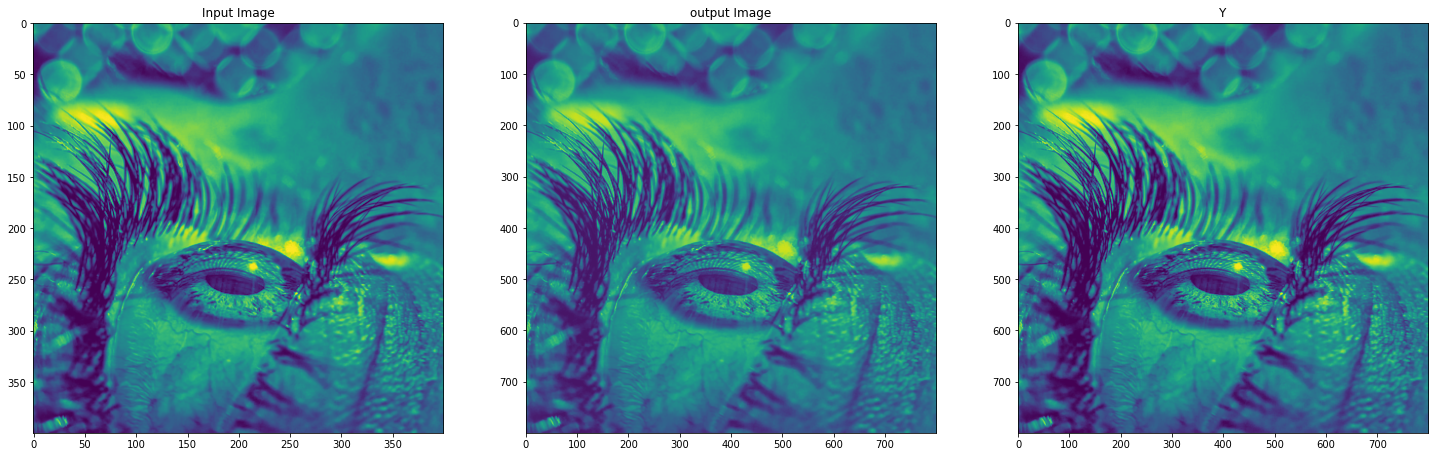

In [8]:
output_image=np.array(output_image)
image=Image.open("/home/raguhtic/Codes/Different Precision SRHW/eye1_1000.jpg")
newsize = (800, 800)
image = image.resize(newsize)
imlryuv=image.convert('YCbCr')
y,u,v=imlryuv.split()
y=np.array(y).astype(np.float32)
y=y/255

# plt.figure(figsize=(5,5))
# plt.imshow(y)
output_image=np.reshape(output_image,(800,800))
plt.figure(figsize=(25,25))
plt.subplot(131)
plt.title('Input Image')
plt.imshow(input_image)
plt.subplot(132)
plt.title('output Image')
plt.imshow(output_image)
plt.subplot(133)
plt.title('Y')
plt.imshow(y)



In [9]:
from math import log10, sqrt
import cv2
import numpy as np
import math
  


def psnr(SR,HR):
  diff=np.subtract(HR,SR)
  mse=np.mean(np.power(diff,2))
  return -10*math.log10(mse)
def main():
#      original = cv2.imread("original_image.png")
#      compressed = cv2.imread("compressed_image.png", 1)
     value = psnr(y, output_image)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 37.04731831187356 dB


In [10]:
from skimage.metrics import structural_similarity as ssim
ssim=ssim(output_image,y)
print("SSIM(Structural Simularity) :",ssim)

SSIM(Structural Simularity) : 0.9912724672907927
